In [468]:
#  Organize the data in a way suitable to use for statistics.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import nan

# ------ LOAD data-tables ---------------------------------------------------- 
# List of clinical table with features and timepoints
path_Klinisk  = "/Users/mattesa/molbreastlab-storage/work/Radiation_study/Matteo/ClinicalData_Klinisk.csv" 
path_Oversikt = "/Users/mattesa/molbreastlab-storage/work/Radiation_study/Matteo/ClinicalData_Oversikt.csv" 
path_Lipopro  = "/Users/mattesa/molbreastlab-storage/work/Radiation_study/Matteo/Lipoproteinene_Combined2.csv" 

root_path = os.path.dirname(path_Lipopro)
             
# Load clinical data file: it contains all the metadata on medications, 
# treatments, sample collection timepoints etc...
# Specifically, load the sheets "Oversikt" and "Klinik fra Randi"
CD_klinisk = pd.read_csv( path_Klinisk,  header=1, index_col=False)
CD_oversik = pd.read_csv( path_Oversikt, header=0, index_col=False)
   
# Load Lipoprotein measurments file: it contains all the measurments for all 
# the blood plasma lipoproteins (only). 
# NOTE: There are some redundant columns
LP_measure = pd.read_csv( path_Lipopro, header=0, index_col=False)


# ------ PRUNING the data ----------------------------------------------------
# Extract the timepoints as defined by Guro, but also the date itself, which 
# can be used to pairs entries in different tables.
#result = pd.merge(left, right, on="key")
sele_oversik  = [ "PatientID", 
                  "Samplenames lipo", "Names date modified", "Samling date", 
                  "Dato stråleterapi", "Timepoint", "Timepoint_kodet" ]
CD_timepoints = CD_oversik.loc[:,sele_oversik]

# COL "Samplenames lipo" in CD_oversik === COL "name" in LP_measure

# Find missing samples, samples (CD_oversik) that have no measurement (LP_measure)
# Do set-difference to find missing samples, then a second one to remove them 
# from the list, and in turn from the dataframe
miss_nn = np.setdiff1d( CD_timepoints["Samplenames lipo"], LP_measure["name"])
list_nn = np.setdiff1d( CD_timepoints["Samplenames lipo"], miss_nn )
CD_timepoints = CD_timepoints.loc[CD_timepoints["Samplenames lipo"].isin(list_nn)]

# Remove quality control measurments: string value starting with "QC"
mask_QC = ["QC" not in xx   for xx in LP_measure["name"]]
LP_measure    = LP_measure.loc[ mask_QC, : ]
CD_timepoints = CD_timepoints.loc[ mask_QC, : ]

# At this point we should have the exact same entries in both DataFrames. 
# We can sort-by name columns "Samplenames lipo" and "name" should be
# equivalent in both tables
CD_timepoints = CD_timepoints.sort_values("Samplenames lipo")
LP_measure    = LP_measure.sort_values("name")

# Some timepoints are uncategorized, and must be removed
mask = CD_timepoints["Timepoint_kodet"].isnull().values
LP_measure    = LP_measure.loc[ ~mask, : ]
CD_timepoints = CD_timepoints.loc[ ~mask, : ]

# Now that we have same order and have sorted tables, we can reindex both.
# Thus, both are sorted and have same row index
LP_measure = LP_measure.reset_index(drop=True)
CD_timepoints = CD_timepoints.reset_index(drop=True)

# ------ SAVE ----------------------------------------------------------------
# Save as Python-Ready .csv file
LP_measure.to_csv(    root_path + "/PyR_Lipoproteine.csv", header=True, index=True)
CD_timepoints.to_csv( root_path + "/PyR_Timepoints.csv"  , header=True, index=True)

In [469]:

# ****************************************************************************

# Module contains functions to optimize and cross validate PLS

# ****************************************************************************

import numpy   as np
import pandas  as pd
import sklearn as skl

import matplotlib.pyplot as plt

from sys import stdout

# ****************************************************************************

# COMMON variables: local function variables (NOT global) that are very
# similar in use and content, thus we use similar names
#
#  - M_x     M_xx     M_xxx  : (DataFrame) data to fit; cols are predictors
#  - M_y     M_yy     M_yyy  : (DataFrame) target variable; cols are responses
#  - Ncomp   opt_Nc          : (int) number of latent variables to test


def pls_CrossVal( M_x, M_y, Ncomp, cv_split):
    # Define PLS object with Ncomp components. Then, using scikit-learn, apply
    # PLSRegression to get cross-validated estimates for each input data point
    #
    # INPUT:
    #   - M_x      - M_y      - Ncomp
    #   - cv_split : (obj or int) cross-validation splitting strategy
    # OUTPUT:
    #   - M_y_cv   : (np.array) estimated probability for predictors

    funPLS = skl.cross_decomposition.PLSRegression( n_components = Ncomp )
    M_y_cv = skl.model_selection.cross_val_predict( funPLS,  M_x,  M_y,  cv= cv_split)

    return M_y_cv


def optimise_PLS_CrossVal( M_xx, M_yy, Ncomp, test_prop, plot_MSE):
    # Map the function "pls_CrossVal" to test PLS with a range of number of
    # components, going from from 1 to maximum of "Ncomp". Option plot_MSE
    # determines whether to display the MSE and R2 plots and estimated optimal
    # number of components
    #
    # INPUT:
    #   - M_xx     - M_yy     - Ncomp
    #   - test_prop: (int) % size of the k-fold. From this value the function
    #                will create the k-fold groups for the test
    #   - plot_MSE : (bool) choose to plot MSE and R2 charts
    # OUTPUT:
    #   - mse      : mean square estimate
    #   - r2       : coefficient of estimation R-squared

    # Create selection function, for K-fold cross-validation with shuffle
    values = np.array(M_xx.index.values)
    k_fold = round(len(values) / round((len(values) * test_prop )) )
    kf_idx = skl.model_selection.KFold(n_splits=k_fold, shuffle=True, random_state=1)

    # Perform PLS regressions for full range of N components, using k-fold
    # sampling method kf_idx and calculate the scores
    mse = []
    r2  = []
    components = np.arange(1, Ncomp)
    
    for ii in components:
        M_yy_cv = pls_CrossVal( M_xx, M_yy, ii, kf_idx)
        # Calculate scores for MSE and R2
        mse.append( skl.metrics.mean_squared_error( M_yy, M_yy_cv) )
        r2.append(  skl.metrics.r2_score( M_yy, M_yy_cv) )
        # Show computation progress and update status on the same line
        #progress = 100*(ii+1)/Ncomp
        #stdout.write("\r%d%% completed" % progress)
        #stdout.flush()
                  
    if plot_MSE is True:
        print("\n")
        plot_metrics(mse, 'MSE', 'min')
        # plot_metrics(r2 , 'R2' , 'max')

    return mse, r2


def plot_metrics(vals, ylabel, objective):
    # Function to plot an np.array "vals" (either MSE or R2 from cross-valid.
    # of PLS) and display the min or max value with a cross
    fig, ax = plt.subplots(figsize=(8, 3))
    xticks = np.arange(1, len(vals)+1)

    plt.plot(xticks, np.array(vals), '-v', color='blue', mfc='blue')

    if objective=='min':
        idx = np.argmin(vals)
    else:
        idx = np.argmax(vals)
    plt.plot(xticks[idx], np.array(vals)[idx], 'P', ms=10, mfc='red')

    ax.set_label('Number of PLS components in regression')
    ax.set_ylabel(ylabel)
    ax.set_xticks( xticks )
    plt.grid(color = "grey", linestyle='--')
    plt.title('PLS cross-val')

    plt.show()


def PLS_fit_model(M_xxx, M_yyy, opt_Nc, response_variable_name):
    # Perform PLS regression and return the transformed training sample scores
    #
    # INPUT:
    #   - M_xxx    - M_yyy    - opt_Nc
    #   - response_variable_name : column name used from M_yyy table
    # OUTPUT:
    #   - DF_PLS_scores : (DataFrame) with the latent var. scores and the
    #                     M_yyy values in the last columns

    # Define PLS object with opt_Nc components. No scaling is necessary
    # (data was already scaled)
    plsr = skl.cross_decomposition.PLSRegression(n_components= opt_Nc , scale=False)

    # Build a PLS-DA model and save the values of opt_N_comp scores in DataFrame
    # together with the YY response table
    plsr.fit( M_xxx, M_yyy)
    scores = plsr.x_scores_
    DF_PLS_scores = pd.DataFrame(data = scores, columns= ["Score_LV_"+str(xx+1) for xx in np.arange(opt_Nc)] )
    DF_PLS_scores[ response_variable_name ] = np.array(M_yyy)

    return DF_PLS_scores

# ****************************************************************************


In [499]:
import sys
# Add as desired to the list of known working paths for Python 
# sys.path.append('F:/Python/')

#import mbc_PLS
#from mbc_PLS import *
# Force reload during development, otherwise Python only load the first time 
# and does not update unless the kernel is rebooted
#import importlib
#importlib.reload(mbc_PLS)

import random

import sklearn
from sklearn.preprocessing       import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection     import cross_val_predict


# --- 1 --- Preparing the data to model with PLS -----------------------------
# Split into training and test sets. Then, find suggested number of minimum 
# components and use it to create a model and obtain the scores for the 
# modelled latent variables
max_N_comp = 20
prop_train2test = 0.2
p_threshold = 0.5
double_cv_loop = 10
CE = []

# Data 
group_category = "Timepoint_kodet"


# Make a copy of the predictors DataFrame and scale-standardize varaibles
XX_vars = LP_measure.iloc[:, 3:].copy()

# Standardizing the features - Use StandardScaler to standardizing the 
# features onto a unit scale with mean = 0 and variance = 1   ( z= (x-u)/s )
temp_FT   = StandardScaler().fit_transform( XX_vars )
# reformat it in proper pd.DataFrame
rows = XX_vars.index.values
cols = XX_vars.columns.values
XX_vars_scaled = pd.DataFrame( temp_FT, index=rows , columns= cols)
XX_scaled = pd.concat( [LP_measure.iloc[:, :3], XX_vars_scaled], axis=1) 


# Prepare the data we wish to use for the PLS mosel in XX and YY dataframes.
YY = CD_timepoints.copy()
# Prepare the data we wish to use for the PLS mosel in XX and YY dataframes.
sele_indexes = YY.loc[ YY[group_category] == 2 , "PatientID" ].index.values
sele_indexes = np.concatenate( (sele_indexes, 
                                YY.loc[ YY[group_category] ==5, "PatientID" ].index.values ))

YY = YY.loc[ sele_indexes ]
#temp = YY[group_category].copy()
#temp[  YY[group_category] ==2 ] = 0
#temp[  YY[group_category] ==5 ] = 1
#YY = temp
XX = XX_scaled.loc[ sele_indexes ]
XX = XX.iloc[:,3:]





# --- 2 --- Cross-validation of PLS ------------------------------------------
# Perform cross validation of PLS and find the "optimal" number of components 
# to use for modelling
cvMSE = []
for cc in range( double_cv_loop ):
    #X_train, X_test ,Y_train, Y_test = sklearn.model_selection.train_test_split( 
    #                                       XX,  YY,  test_size= prop_train2test, 
    #                                       random_state=None)

 
    pID_List  = np.unique( [xx.split("_")[0]  for xx in YY["PatientID"].values] )

    test_pID  = random.sample( pID_List.tolist(), round(len(pID_List)*prop_train2test) )
    test_idx  = YY["PatientID"].isin( test_pID ).values

    train_pID = np.setdiff1d(pID_List, test_pID)
    train_idx = YY["PatientID"].isin( train_pID ).values

    print("pID_List  - ", len(pID_List) )
    print("train_pID - ", len(train_pID) )
    print("test_pID  - ", len(test_pID) )

    print("test_idx  = ", test_idx.sum() )
    print("train_idx = ", train_idx.sum() )
    print("Total     - ", test_idx.sum()+train_idx.sum() )

    X_train = XX.loc[ train_idx, : ]
    X_test  = XX.loc[ test_idx,  : ]
    Y_train = YY.loc[ train_idx, group_category ]
    Y_test  = YY.loc[ test_idx,  group_category ]

    #check_X = pd.Series(X_train["name"].unique()).isin( X_test["name"].unique()).any()
    #check_Y = pd.Series(Y_train["PatientID"].unique()).isin( Y_test["PatientID"].unique()).any()
    #
    #if check_X or check_Y:
    #   print("WARNING: slection data inappropriate!")
        
    
    MSE, R2 = optimise_PLS_CrossVal( X_train, Y_train, max_N_comp, prop_train2test, False)
    cvMSE.append( MSE )
    mse_min = np.argmin(MSE)

    kf_idx = skl.model_selection.KFold(n_splits=6, shuffle=True, random_state=None)
    Y_test_prediction = pls_CrossVal(X_test, Y_test, mse_min, kf_idx)

    # Convert to a Boolean array using p_threshold value as condition. Transform 
    # to 0-1 array and flatten, and compare to Y_test to calculate calibration efficiency
    Y_test_thres = Y_test_prediction > p_threshold
    Y_test_thres = Y_test_thres.astype(float).flatten()
    temp_ce = [ qq == ee for qq,ee in zip(Y_test.values, Y_test_thres) ]
    CE.append(sum(temp_ce) / len(temp_ce))


print("Suggested number of components: ", mse_min+1) 
print("Calibration efficiency is     :  " + "{:.2f}".format(CE))

    
#PLS_scores = PLS_fit_model(X_test, Y_test, mse_min, group_category)


pID_List  -  234
train_pID -  187
test_pID  -  47
test_idx  =  74
train_idx =  286
Total     -  360
pID_List  -  234
train_pID -  187
test_pID  -  47
test_idx  =  74
train_idx =  286
Total     -  360
pID_List  -  234
train_pID -  187
test_pID  -  47
test_idx  =  75
train_idx =  285
Total     -  360
pID_List  -  234
train_pID -  187
test_pID  -  47
test_idx  =  78
train_idx =  282
Total     -  360
pID_List  -  234
train_pID -  187
test_pID  -  47
test_idx  =  76
train_idx =  284
Total     -  360
pID_List  -  234
train_pID -  187
test_pID  -  47
test_idx  =  69
train_idx =  291
Total     -  360
pID_List  -  234
train_pID -  187
test_pID  -  47
test_idx  =  67
train_idx =  293
Total     -  360
pID_List  -  234
train_pID -  187
test_pID  -  47
test_idx  =  76
train_idx =  284
Total     -  360
pID_List  -  234
train_pID -  187
test_pID  -  47
test_idx  =  74
train_idx =  286
Total     -  360
pID_List  -  234
train_pID -  187
test_pID  -  47
test_idx  =  73
train_idx =  287
Total     -  360


TypeError: unsupported format string passed to list.__format__

(-15, 15)

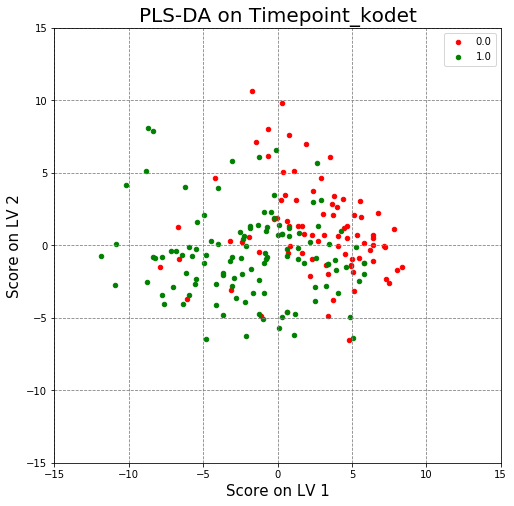

In [7]:

# --- 3 --- Plot PLS by group_category --------------------------------------------

# We create a 2D scatter plot, we only need to take the first two latent 
# variables and the response column (the last). We color each category 
# (targets) with a unique color
plotDF = PLS_scores.iloc[:,[0,1,-1]]

targets = np.sort( plotDF[group_category].unique() )
colors  = ['r', 'g', 'b', 'k', 'm', 'c', 'o']

fig = plt.figure(figsize = (8,8))
ax  = fig.add_subplot(1,1,1) 

# Plot the PCA in as 2D scatterplot and uniquely  color each flowcell data
for target, color in zip(targets,colors):
    ind_xx = plotDF[group_category] == target
    ax.scatter( plotDF.loc[ind_xx, 'Score_LV_1'], 
                plotDF.loc[ind_xx, 'Score_LV_2'], 
                c = color,
                s = 20)
ax.set_xlabel('Score on LV 1', fontsize = 15)
ax.set_ylabel('Score on LV 2', fontsize = 15)
ax.set_title('PLS-DA on '+ group_category , fontsize = 20)
ax.legend(targets)
plt.grid(color = "grey", linestyle='--')
nn = 15
ax.set_xlim([-nn, nn])
ax.set_ylim([-nn, nn])

# --- SAVE the plot ----------------------------------------------------------
# plt.savefig("PLS-DA_Timepoint_"+region+".svg")

In [500]:
CE

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

SyntaxError: invalid syntax (<ipython-input-494-11925c77b098>, line 1)

In [496]:
YY

,PatientID,Samplenames lipo,Names date modified,Samling date,Dato stråleterapi,Timepoint,Timepoint_kodet
1,17196,17196_14.08.07,17196_14.08.2007,14.08.2007,11/07/2007,post,2.0
6,17547,17547_26.04.07,17547_26.04.2007,26.04.2007,20/03/2007,post,2.0
9,17548,17548_25.06.2007,17548_25.06.2007,25.06.2007,19/03/2007,post,2.0
12,17606,17606_13.06.07,17606_13.06.2007,13.06.2007,21/05/2007,post,2.0
18,17805,17805_24.04.07,17805_24.04.2007,24.04.2007,15/03/2007,post,2.0
...,...,...,...,...,...,...,...
972,19904,19904_30.09.2009,19904_30.09.2009,30.09.2009,18/09/2008,12 months,5.0
975,19930,19930_27.10.2009,19930_27.10.2009,27.10.2009,25/09/2008,12 months,5.0
978,19943,19943_14.08.2009,19943_14.08.2009,14.08.2009,01/10/2008,12 months,5.0
981,19944,19944_03.11.2009,19944_03.11.2009,03.11.2009,01/10/2008,12 months,5.0
